In [68]:
import os
import cv2
import math
import dlib
import PIL
import operator
import datetime
import itertools
import statistics
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [69]:
from sklearn.pipeline import Pipeline

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imutils import face_utils
from sklearn.svm import SVC

In [71]:
# Declaration of functions
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def print_image(image,title=''):
    if verbosity==False:
        return
    figure = plt.figure()
    plt.title(title)
    plt.imshow(image)

def symmetry_deviation(shape):
    # calculate symmetry line of shape (left-right lines)
    (m1,b1,x_val,y_val) = left_right_symmetry_line(shape)
    reg_line = [(m1*x)+b1 for x in x_val]

    if verbosity==True:
        plt.plot(x_val,reg_line)

    # main symmetry line of shape (nose-chin line)
    (m2,b2,x_val,y_val) = main_symmetry_line(shape)
    reg_line = [(m2*x)+b2 for x in x_val]

    if verbosity==True:
        plt.plot(x_val,reg_line)
    
    # determin deviation of two lines
    err = abs(math.degrees(math.atan((m1-m2)/(1+m1*m2))))
    return err

def left_right_symmetry_line(shape):
    shape = shape.tolist()
    points = [ (21,22), (18,25), (36,45), (39,42), (31,35), (48,54), (50,52), (58,56), (5,11), (1,15), (3,13), (7,9) ]
    x_val = []
    y_val = []
    for item in points:
        left_point = shape[item[0]]
        right_point = shape[item[1]]
        (x,y) = line_centre(left_point,right_point)
        x_val.append(x)
        y_val.append(y)
        
    (m,b) = slope_interception(x_val,y_val)
    return m,b,x_val,y_val

def line_centre(x,y):
    return [int(round((x[0]+y[0])/2)),int(round((x[1]+y[1])/2))]

def slope_interception(x_val,y_val):
    x = np.array(x_val)
    y = np.array(y_val)
    m = ( ((np.mean(x)*np.mean(y)) - np.mean(x*y)) / ((np.mean(x)*np.mean(x)) - np.mean(x*x)) )
    m = round(m,2)
    b = (np.mean(y) - np.mean(x)*m)
    b = round(b,2)
    # y = m*x+b
    return m,b

def main_symmetry_line(shape):
    shape = shape.tolist()
    points = [27,27,29,30,33,51,62,66,57,8]
    x_val = []
    y_val = []
    for item in points:
        point = shape[item]
        x_val.append(point[0])
        y_val.append(point[1])
        
    (m,b) = slope_interception(x_val,y_val)
    return m,b,x_val,y_val

def golden_ratio(shape):
    GR = 1.62
    err_list = [] # sum of square errors
    
    # odnos debljina usne - sirina nosa
    x1 = get_lips_height(shape)
    x2 = get_nose_width(shape)
    err_list.append((GR-x1/x2)**2)
    
    # odnos sirina nosa i razmak usana od nosa
    x1 = get_nose_width(shape)
    mouth_centre = line_centre(shape[62],shape[66])
    x2 = euclidean_distance(shape[33][0],shape[33][1],mouth_centre[0],mouth_centre[1])
    err_list.append((GR-x1/x2)**2)
    
    # odnos razmaka od vrha nosa do brade i razmak usana od vrha brade
    x1 = euclidean_distance(shape[33][0],shape[33][1],shape[8][0],shape[8][1])
    x2 = euclidean_distance(shape[8][0],shape[8][1],mouth_centre[0],mouth_centre[1])
    err_list.append((GR-x1/x2)**2)
    
    # jednak odnos sirine ociju i sirine medjuocnog prostora
    x1 = euclidean_distance(shape[36][0],shape[36][1],shape[39][0],shape[39][1])
    x2 = euclidean_distance(shape[42][0],shape[42][1],shape[45][0],shape[45][1])
    eye_width = (x1+x2)/2
    x3 = get_eye_distance(shape)
    
    err = eye_width/x3
    if (err<0):
        err = x3/eye_width
    
    err_list.append(err**2)
    
    # jednak odnos po visini
    left_eye = line_centre(shape[36],shape[39])
    right_eye = line_centre(shape[42],shape[45])
    eyes = line_centre(left_eye,right_eye)
    
    x1 = euclidean_distance(shape[33][0],shape[33][1],eyes[0],eyes[1])
    x2 = euclidean_distance(shape[33][0],shape[33][1],shape[8][0],shape[8][1])
    
    err = x1/x2
    if (err<0):
        err = x2/x1
    
    err_list.append(err**2)
    
    return sum(err_list)

def get_nose_width(shape):
    shape = shape.tolist()
    high_point = shape[31]
    low_point = shape[35]
    return euclidean_distance(high_point[0],high_point[1],low_point[0],low_point[1])

def get_lips_height(shape):
    shape = shape.tolist()
    high_point = shape[51]
    low_point = shape[57]
    return euclidean_distance(high_point[0],high_point[1],low_point[0],low_point[1])

def get_eye_distance(shape):
    shape = shape.tolist()
    left_point = shape[39]
    right_point = shape[42]
    return euclidean_distance(left_point[0],left_point[1],right_point[0],right_point[1])

def euclidean_distance(x1,y1,x2,y2):
    return math.hypot(x2 - x1, y2 - y1)

def skin_wrinkles(shape,face_image):
    shape = shape.tolist()
    xmin = shape[42][0]
    ymax = shape[30][1]
    xmax = shape[45][0]
    ymin = shape[28][1]

    #cv2.rectangle(face_image,(xmin,ymin),(xmax,ymax),(0,255,0),3)
    #print_image(face_image,'skin wrinkles')
                
    skin = face_image[ymin:ymax, xmin:xmax]
    gray_skin = cv2.cvtColor(skin, cv2.COLOR_RGB2GRAY)
    
    v = np.median(gray_skin)
    sigma = 0.33    
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(gray_skin, lower, upper)
    
    white_pixels = np.sum(edged == 255)
    width,height = edged.shape
    total_pixels = width*height
    
    return (white_pixels/total_pixels)*100

def skin_redness(shape,face_image):
    shape = shape.tolist()
    xmin = shape[42][0]
    ymax = shape[30][1]
    xmax = shape[45][0]
    ymin = shape[28][1]
    
    skin = face_image[ymin:ymax, xmin:xmax]
    size = skin.size
    
    #print_image(skin, 'Skin redness 2')
    
    RED_MIN = np.array([0,0,128], np.uint8)
    RED_MAX = np.array([250, 250, 255], np.uint8)
    
    dstr = cv2.inRange(skin, RED_MIN, RED_MAX)
    no_red = cv2.countNonZero(dstr)
    frac_red = np.divide((float(no_red)),(int(size)))
    percent_red = frac_red*100
    
    return percent_red

def average(l): 
    return sum(l)/len(l)


In [72]:
#matplotlib.rcParams['figure.figsize'] = 20,16


# Declaration of variables
verbosity=False
basewidth=320

image_list = {}
temp_list = {}

pos_list_redness = []
pos_list_wrinkles = []
pos_list_symmerty = []
pos_list_golden_ratio = []
neg_list_redness = []
neg_list_wrinkles = []
neg_list_symmerty = []
neg_list_golden_ratio = []

pos_features = []
neg_features = []
labels = []

image_dir_pos = 'slike/positive'
image_dir_neg = 'slike/negative'

print('\n*** An algorithm that extracts the features from face image and inserts them in SVM and KNN for \'smart\' detection of drug addicts ***')
start_time = datetime.datetime.utcnow()
print('\nProcess started at ', start_time,'\n')

# Algorithm 1: Download all images from the folder
for img_name in os.listdir(image_dir_pos):
    img_path = os.path.join(image_dir_pos, img_name)
    img = load_image(img_path)
    img_name = "pos_" + img_name
    image_list[img_name]=img
    
for img_name in os.listdir(image_dir_neg):
    img_path = os.path.join(image_dir_neg, img_name)
    img = load_image(img_path)
    img_name = "neg_" + img_name
    image_list[img_name]=img

# Algorithm 2: Image preprocessing
#for img_name in image_list:
#	img = image_list[img_name]
#	wpercent = (basewidth / float(img.shape[0]))
#	hsize = int((float(img.shape[1]) * float(wpercent)))
#	img = cv2.resize(img, (basewidth, hsize), PIL.Image.ANTIALIAS)
#	temp_list[img_name]=img
#
#image_list = temp_list

p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)



*** An algorithm that extracts the features from face image and inserts them in SVM and KNN for 'smart' detection of drug addicts ***

Process started at  2019-08-18 08:50:09.775140 



In [73]:
for name in image_list:
    image = image_list[name]
    original = image.copy()
    features = []
    
    if verbosity==True:
        print('\nThe image being processed is ' + name)
    
    # Converting the image to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	# Algorithm 3: Face landmarks extraction
    rects = detector(gray, 0)

    # For each detected face, find the landmark.
    for (i, rect) in enumerate(rects):
        # Make the prediction and transfom it to numpy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

    # Draw on our image, all the finded cordinate points (x,y) 
    for (x, y) in shape:
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)        
    
    # Show the image with landmarks
    print_image(image,name)
    
    # Algorithm 4: Symmetry of the face
    symmetry = symmetry_deviation(shape)
    if verbosity==True:
        print('Deviation from the Symmetry is ' + str(symmetry) + '° (less is better, ideally 0)')
    features.append(symmetry)

	# Algorithm 5: Golden ratio
    gr = golden_ratio(shape)
    if verbosity==True:
        print('The deviation from the Golden Ratio is ' + str(gr) + ' (less is better, ideally 1)')
    features.append(gr)
 
    # Algorithm 6: Skin wrinkles
    wrinkles = skin_wrinkles(shape,original)
    if verbosity==True:
        print('The percentage of wrinkles is ' + str(wrinkles) + '% (less is better, ideally 0)')
    features.append(wrinkles)
    
    # Algoritam 7: Skin redness
    redness = skin_redness(shape,original)
    if verbosity==True:
        print('The percentage of skin redness is ' + redness + '% (less is better, ideally 0)')
    features.append(redness)
    
    
    # Algorithm 8: Preparation for classification
    img_type = name.split("_", 1)[0]
    if (img_type=="pos"):
        pos_features.append(features)
        labels.append(1)
        pos_list_redness.append(redness)
        pos_list_wrinkles.append(wrinkles)
        pos_list_symmerty.append(symmetry)
        pos_list_golden_ratio.append(gr)
    else:
        neg_features.append(features)
        labels.append(0)
        neg_list_redness.append(redness)
        neg_list_wrinkles.append(wrinkles)
        neg_list_symmerty.append(symmetry)
        neg_list_golden_ratio.append(gr)

print('\nThe results (negative):')
print('The average deviation from the Symmetry is     ' + str(average(neg_list_symmerty)) + '° (less is better, ideally 0)')
print('The average deviation from the Golden Ratio is ' + str(average(neg_list_golden_ratio)) + ' (less is better, ideally 1)')
print('The average percentage of wrinkles is          ' + str(average(neg_list_wrinkles)) + '% (less is better, ideally 0)')
print('The average percentage of redness is           ' + str(average(neg_list_redness)) + '% (less is better, ideally 0)')

print('\nThe results (positive):')
print('The average deviation from the Symmetry is     ' + str(average(pos_list_symmerty)) + '° (less is better, ideally 0)')
print('The average deviation from the Golden Ratio is ' + str(average(pos_list_golden_ratio)) + ' (less is better, ideally 1)')
print('The average percentage of wrinkles is          ' + str(average(pos_list_wrinkles)) + '% (less is better, ideally 0)')
print('The average percentage of redness is           ' + str(average(pos_list_redness)) + '% (less is better, ideally 0)')



The results (negative):
The average deviation from the Symmetry is     5.442260684372674° (less is better, ideally 0)
The average deviation from the Golden Ratio is 2.2007531721213147 (less is better, ideally 1)
The average percentage of wrinkles is          2.112936532227858% (less is better, ideally 0)
The average percentage of redness is           13.960059382879313% (less is better, ideally 0)

The results (positive):
The average deviation from the Symmetry is     3.1618658817019893° (less is better, ideally 0)
The average deviation from the Golden Ratio is 2.401929398814241 (less is better, ideally 1)
The average percentage of wrinkles is          2.934147765635157% (less is better, ideally 0)
The average percentage of redness is           15.519719024995124% (less is better, ideally 0)


In [74]:
# Algorithm 8: Preparation for classification
pos_features = np.array(pos_features)
neg_features = np.array(neg_features)
x = np.vstack((pos_features, neg_features))
y = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

end_prep_time = datetime.datetime.utcnow()

#  Algorithm 9: SVM classification
start_svm_time = datetime.datetime.utcnow()
svm = SVC(kernel='linear', probability=True) 
svm.fit(x_train, y_train)
y_train_pred = svm.predict(x_train)
y_test_pred = svm.predict(x_test)
print("\nSVM Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("SVM Validation accuracy: ", accuracy_score(y_test, y_test_pred))
end_svm_time = datetime.datetime.utcnow()

# Algorithm 10: KNN classification
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(x_train, y_train)
y_train_pred = knn.predict(x_train)
y_test_pred = knn.predict(x_test)
print("\nKNN Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("KNN Validation accuracy: ", accuracy_score(y_test, y_test_pred))


end_time = datetime.datetime.utcnow()
print('\nProcess ended at ', end_time)
print('The process lasted ', end_time-start_time)

print('\nThe preparation of images lasted ', end_prep_time-start_time)
print('The SVM classification of images lasted ', end_svm_time-start_svm_time)
print('The KNN classification of images lasted ', end_time-end_svm_time)



SVM Train accuracy:  0.616822429906542
SVM Validation accuracy:  0.6111111111111112

KNN Train accuracy:  0.7663551401869159
KNN Validation accuracy:  0.5185185185185185

Process ended at  2019-08-18 08:50:55.202481
The process lasted  0:00:45.427341

The preparation of images lasted  0:00:45.315931
The SVM classification of images lasted  0:00:00.103574
The KNN classification of images lasted  0:00:00.007789


In [8]:
class_names = ['negative', 'positive']
report = classification_report(y_test, y_test_pred, target_names = class_names)
print(report)

              precision    recall  f1-score   support

    negative       0.43      0.59      0.50        22
    positive       0.62      0.47      0.54        32

    accuracy                           0.52        54
   macro avg       0.53      0.53      0.52        54
weighted avg       0.55      0.52      0.52        54



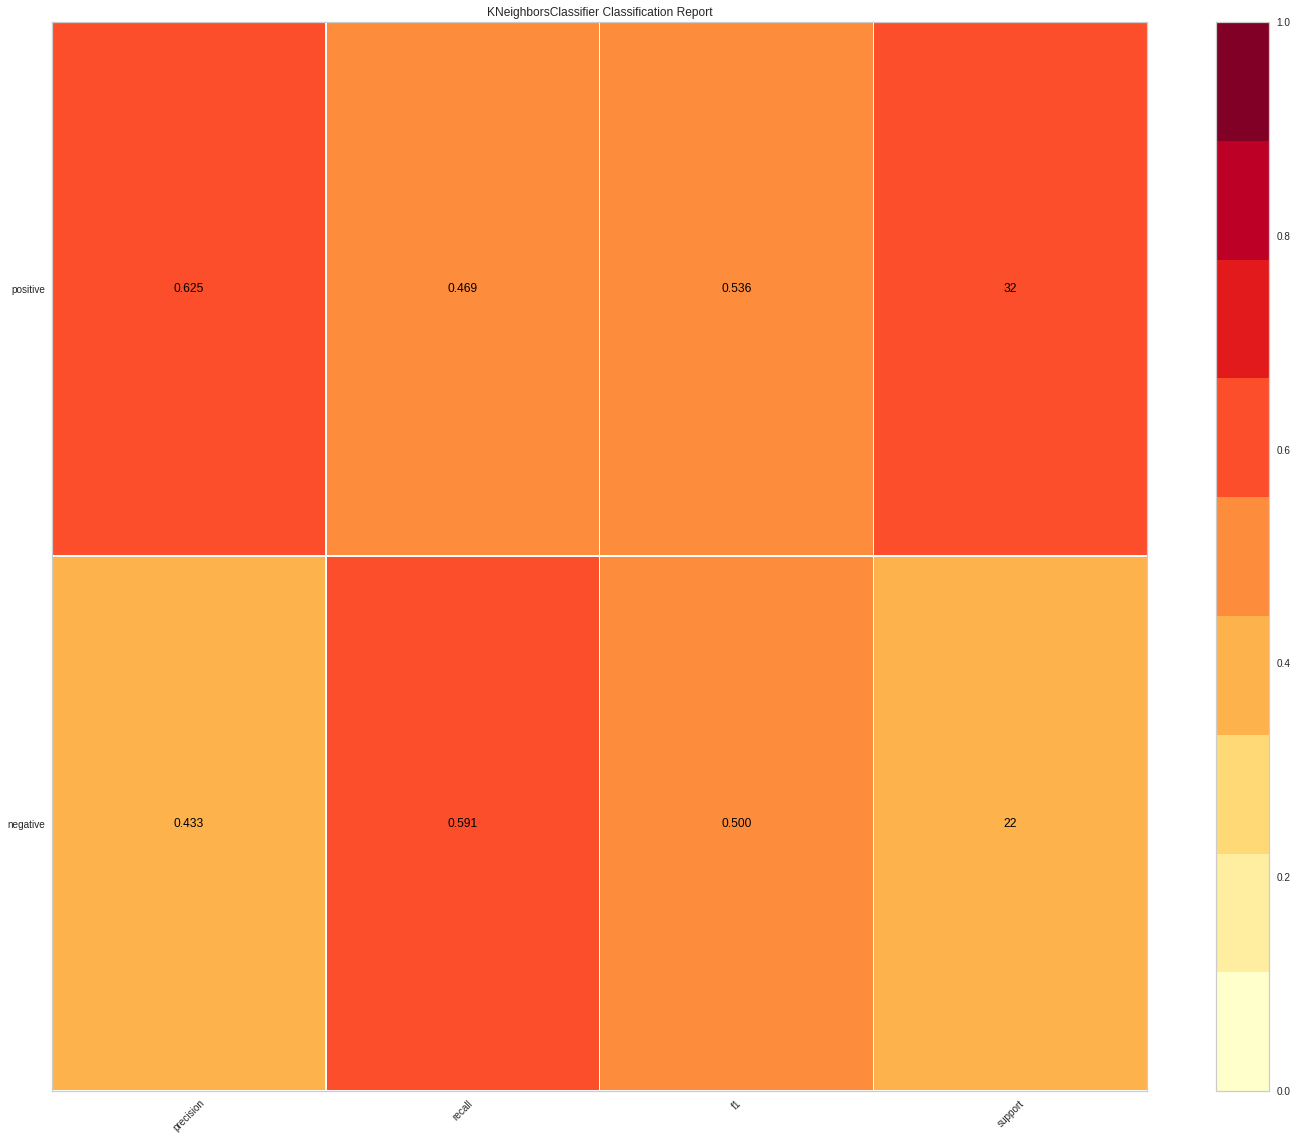

In [75]:
visualizer = ClassificationReport(knn, classes = class_names, support = True)
visualizer.fit(x_train,y_train)
visualizer.score(x_test,y_test)
g = visualizer.poof()

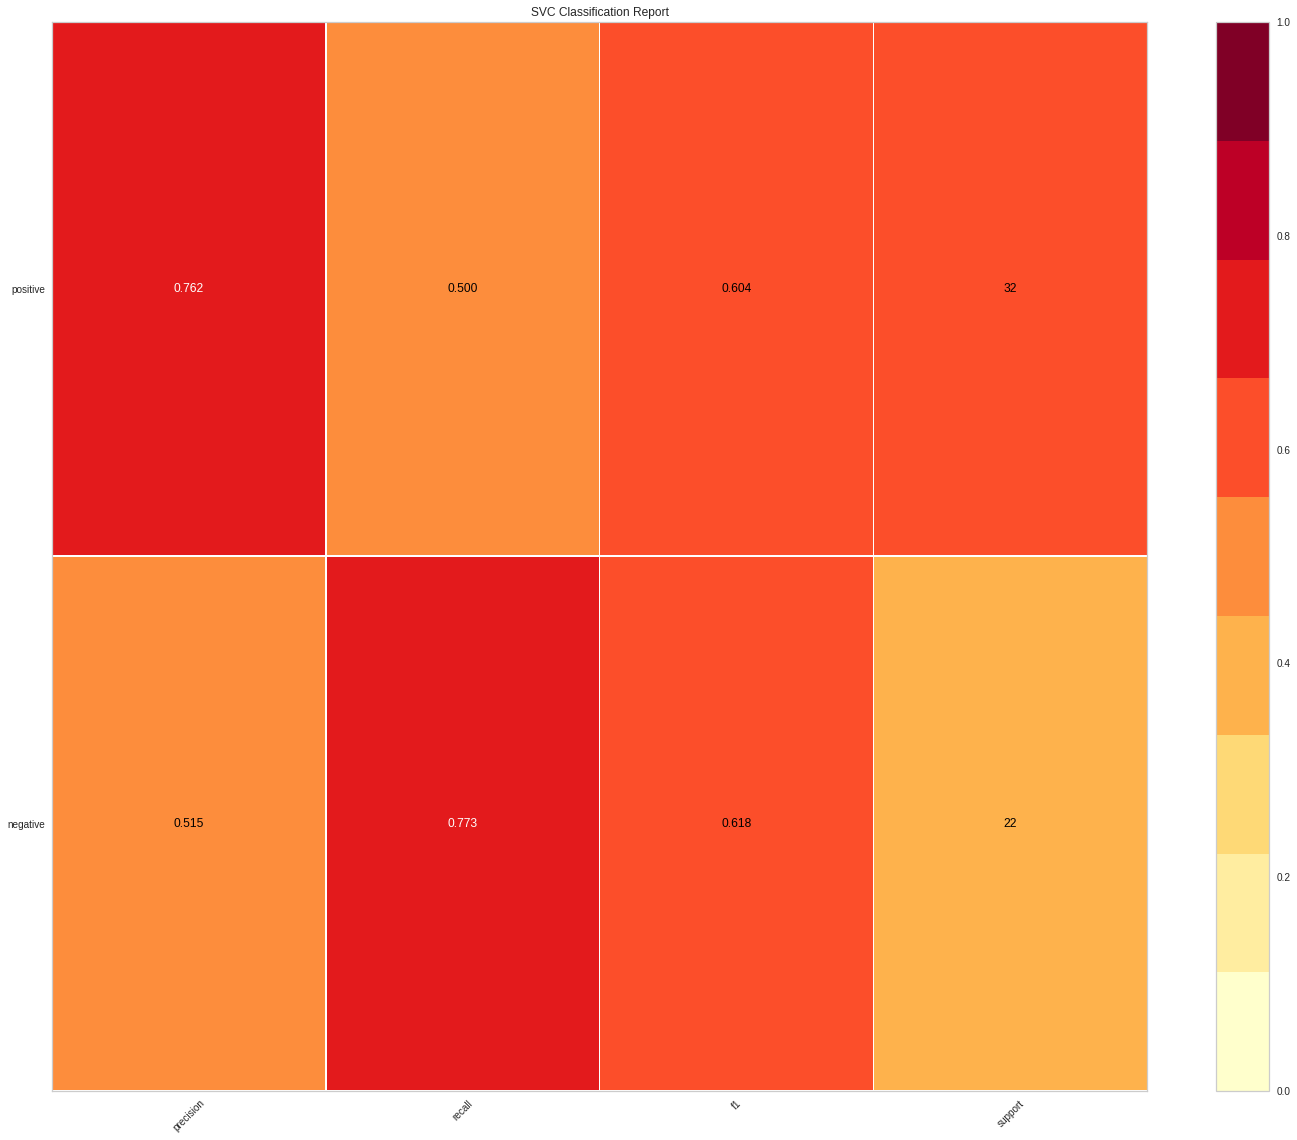

In [10]:
visualizer = ClassificationReport(svm, classes = class_names, support = True)
visualizer.fit(x_train,y_train)
visualizer.score(x_test,y_test)
g = visualizer.poof()

In [11]:
time_array = []
avg_array = []

for j in range(1000):
    for i in range(20):
        x = x_train[i].reshape(1, -1)

        start_time = datetime.datetime.utcnow()
        y = knn.predict(x)
        end_time = datetime.datetime.utcnow()

        time = end_time-start_time
        time_array.append(time.microseconds)
        
    avg_array.append(average(time_array))

print('The process lasted in average (ms)', str(average(avg_array)/1000))

The process lasted in average (ms) 0.9115116144833596


In [61]:
pos_list_redness = []
pos_list_wrinkles = []
pos_list_symmerty = []
pos_list_golden_ratio = []
neg_list_redness = []
neg_list_wrinkles = []
neg_list_symmerty = []
neg_list_golden_ratio = []

pos_features = []
neg_features = []
labels = []

for name in image_list:
    image = image_list[name]
    original = image.copy()
    features = []
    
    if verbosity==True:
        print('\nThe image being processed is ' + name)
    
    # Converting the image to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	# Algorithm 3: Face landmarks extraction
    rects = detector(gray, 0)

    # For each detected face, find the landmark.
    for (i, rect) in enumerate(rects):
        # Make the prediction and transfom it to numpy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

    # Draw on our image, all the finded cordinate points (x,y) 
    for (x, y) in shape:
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)        
    
    # Show the image with landmarks
    print_image(image,name)
    
    # Algorithm 4: Symmetry of the face
    symmetry = symmetry_deviation(shape)
    if verbosity==True:
        print('Deviation from the Symmetry is ' + str(symmetry) + '° (less is better, ideally 0)')
    features.append(symmetry)

	# Algorithm 5: Golden ratio
    gr = golden_ratio(shape)
    if verbosity==True:
        print('The deviation from the Golden Ratio is ' + str(gr) + ' (less is better, ideally 1)')
    features.append(gr)
 
    # Algorithm 6: Skin wrinkles
    wrinkles = skin_wrinkles(shape,original)
    if verbosity==True:
        print('The percentage of wrinkles is ' + str(wrinkles) + '% (less is better, ideally 0)')
    features.append(wrinkles)
    
    # Algoritam 7: Skin redness
    redness = skin_redness(shape,original)
    if verbosity==True:
        print('The percentage of skin redness is ' + redness + '% (less is better, ideally 0)')
    features.append(redness)
    
    
    # Algorithm 8: Preparation for classification
    img_type = name.split("_", 1)[0]
    if (img_type=="pos"):
        pos_features.append(features)
        labels.append(1)
        pos_list_redness.append(redness)
        pos_list_wrinkles.append(wrinkles)
        pos_list_symmerty.append(symmetry)
        pos_list_golden_ratio.append(gr)
    else:
        neg_features.append(features)
        labels.append(0)
        neg_list_redness.append(redness)
        neg_list_wrinkles.append(wrinkles)
        neg_list_symmerty.append(symmetry)
        neg_list_golden_ratio.append(gr)
        
    print(name,features)


pos_Y31.jpg [0.13595551120982538, 1.4683246687350087, 0.0, 21.15942028985507]
pos_Y16.jpg [0.04411790640880338, 1.4483636992668405, 3.9183673469387754, 0.0]
pos_T10.jpg [4.620044221637528, 2.5811969542108506, 1.3852813852813852, 31.515151515151512]
pos_X7.jpg [3.2891610260270188, 2.181683624292174, 0.0, 9.346846846846848]
pos_Y39.jpg [0.8598854922195878, 1.775620143293805, 2.898550724637681, 30.434782608695656]
pos_Y70.jpg [0.11520693880787397, 2.178205885513895, 0.0, 12.237237237237238]
pos_Y44.jpg [1.9886072380913433, 1.6233760132986594, 0.8776844070961718, 21.93588546529723]
pos_Y33.jpg [0.1803487334315235, 2.6486040624106106, 6.046511627906977, 9.166666666666666]
pos_X14.jpg [1.3750983345844892, 1.6028259393056756, 18.773946360153257, 0.38314176245210724]
pos_Y60.jpg [0.6707092546454326, 3.1356504925575326, 0.0, 0.03360215053763441]
pos_A10.jpg [0.9669358613253306, 1.732952662870153, 0.0, 1.1075268817204302]
pos_Y71.jpg [0.4044044769262719, 3.403004849833276, 3.75, 5.43981481481481

pos_Y12.jpg [6.161418551466446, 2.7546938379897004, 0.0, 24.215167548500883]
pos_A11.jpg [0.9448148032968539, 3.1783295237885323, 0.0, 27.647442163571196]
pos_X27.jpg [4.161262777631184, 2.9487714915755436, 0.0, 0.0]
pos_X18.jpg [0.3877605154647803, 2.3188117777944686, 0.0, 24.484126984126984]
pos_Y66.jpg [0.5790878292699772, 1.4801435896365558, 18.303030303030305, 19.434343434343436]
pos_Y50.jpg [0.25679379819399795, 3.326184200876637, 0.0, 32.335550628233555]
pos_Y58.jpg [0.20015212201560542, 2.4560557429361642, 2.80437756497948, 0.0]
pos_X9.jpg [6.862088722583319, 2.912751536076737, 0.0, 8.626092693386113]
pos_Y32.jpg [0.650922850629874, 2.1049305568633905, 0.0, 0.5494505494505495]
pos_A2.jpg [1.4467121398261436, 4.137090393791771, 0.21645021645021645, 13.015873015873018]
pos_Y38.jpg [0.7039108902905956, 2.12669166484945, 10.666666666666668, 11.333333333333332]
pos_X5.jpg [2.6111925548562476, 2.1463454029778166, 0.0, 25.24122807017544]
pos_Y47.jpg [0.2981624542625456, 1.817849245542

neg_M36.jpg [2.0046124333056308, 2.6178195195019107, 0.0, 15.716911764705882]
neg_A1.jpg [10.597337701145292, 2.4686016656034386, 0.0, 21.61319073083779]
neg_A9.jpg [1.296393866156864, 1.6724116826059707, 0.0, 0.0]
neg_X8.jpg [0.5394471004190043, 2.2199576451928342, 0.6192959582790091, 0.0]
neg_X50.jpg [6.069948561990441, 2.1917701423813423, 0.0, 19.187336156483163]
neg_Y36.jpg [0.2830129293766826, 2.367723965278862, 0.0, 18.641975308641975]
neg_X49.jpg [1.1579879133888031, 2.248834150446759, 0.0, 11.589635854341736]
neg_X37.jpg [0.3191647228178959, 1.8441764120219264, 0.0, 20.756172839506174]
neg_X46.jpg [72.94797218816959, 2.3326705132556316, 0.0, 29.688888888888886]
neg_Y25.jpg [0.1265447222707613, 2.2610450299647895, 3.7698412698412698, 0.0]
neg_X55.jpg [0.7024028123117976, 2.860038669075534, 0.5306122448979592, 0.0]
neg_Y2.jpg [0.2766012817352677, 2.5733492650580323, 1.1456628477905073, 19.3307874158938]
neg_T5.jpg [10.78818105677994, 1.9115908403305442, 0.0, 26.77777777777778]
ne

/home/student/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars


neg_Y32.jpg [4.707453192693109, 2.4942930559083116, 1.7592592592592593, 0.0]
neg_A2.jpg [0.4766001959090752, 2.4858550045711865, 0.0, 12.606209150326798]
neg_Y38.jpg [1.4662846352442716, 1.9918870413927288, 0.0, 0.0]
neg_X53.jpg [0.503266901270579, 2.278313024557353, 0.0, 17.789598108747047]
neg_X56.jpg [0.23176039563052014, 1.9225633414874044, 0.0, 8.613264427217917]
neg_A3.jpg [1.8436277324180264, 1.5265045089017304, 0.5564648117839607, 2.6950354609929077]
neg_Y17.jpg [0.4109408097179212, 2.3004668063901628, 0.6259780907668232, 6.766525076384232]
neg_Y1.jpg [0.24294301480484792, 2.0243744210643198, 1.3945857260049221, 0.0]
neg_M3.jpg [6.854170531325924, 2.278459185501039, 4.227304227304227, 1.4091014091014091]
neg_T3.jpg [0.20648923429470978, 2.183905596008806, 26.843317972350228, 1.30568356374808]
neg_X22.jpg [1.3029366263726725, 2.438118250615332, 0.0, 0.4154447702834799]
neg_Y13.jpg [3.7638140832083167, 1.5506537083286407, 0.0, 0.0]
neg_X40.jpg [1.452601797629288, 2.01861591418026

In [62]:
for i in range(len(neg_features)):
    print(i,neg_features[i])

0 [0.434757360255744, 2.643556173946768, 0.0, 31.423868312757204]
1 [1.7544449826420099, 2.261498403086663, 0.0, 30.25901398086829]
2 [1.0252559356286355, 2.5290487339892773, 5.180840664711632, 24.50309547083741]
3 [0.2721506568938477, 2.181969281030907, 3.4001743679163035, 0.0]
4 [1.6395800509178549, 2.024366617041657, 0.0, 6.7669172932330826]
5 [0.5297385847232209, 1.9517693265586824, 0.0, 17.1875]
6 [4.511286113699568, 2.2282203709395647, 0.0, 4.665118079752227]
7 [3.3052676919102555, 1.7505708630738037, 0.0, 27.735152031827226]
8 [0.14301552702072773, 1.9973684054933383, 0.0, 6.073835784313726]
9 [0.7725713988113636, 2.498970873984215, 0.0, 32.58258258258258]
10 [0.9963731678312386, 2.0702687690017405, 8.373590982286634, 9.286097691894794]
11 [0.28045898945104325, 1.685151202683678, 11.969696969696969, 21.666666666666668]
12 [0.6227792249647682, 1.92833243734202, 0.4807692307692308, 17.115384615384617]
13 [1.4726115252728573, 1.7882198877842668, 0.0, 1.430882169963917]
14 [0.354485

In [63]:
for i in range(len(pos_features)):
    print(i,pos_features[i])

0 [0.13595551120982538, 1.4683246687350087, 0.0, 21.15942028985507]
1 [0.04411790640880338, 1.4483636992668405, 3.9183673469387754, 0.0]
2 [4.620044221637528, 2.5811969542108506, 1.3852813852813852, 31.515151515151512]
3 [3.2891610260270188, 2.181683624292174, 0.0, 9.346846846846848]
4 [0.8598854922195878, 1.775620143293805, 2.898550724637681, 30.434782608695656]
5 [0.11520693880787397, 2.178205885513895, 0.0, 12.237237237237238]
6 [1.9886072380913433, 1.6233760132986594, 0.8776844070961718, 21.93588546529723]
7 [0.1803487334315235, 2.6486040624106106, 6.046511627906977, 9.166666666666666]
8 [1.3750983345844892, 1.6028259393056756, 18.773946360153257, 0.38314176245210724]
9 [0.6707092546454326, 3.1356504925575326, 0.0, 0.03360215053763441]
10 [0.9669358613253306, 1.732952662870153, 0.0, 1.1075268817204302]
11 [0.4044044769262719, 3.403004849833276, 3.75, 5.439814814814815]
12 [1.28012421608781, 1.9747204904643105, 36.52073732718894, 0.07680491551459294]
13 [0.15027545545828444, 1.75713

In [65]:
pos_features = np.array(pos_features)
neg_features = np.array(neg_features)
x = np.vstack((pos_features, neg_features))
y = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print('stvarna klasa:',y_test[6],', dobijena klasa:',y_test_pred[6],', vrednost x:', x_test[6])
print('stvarna klasa:',y_test[5],', dobijena klasa:',y_test_pred[5],', vrednost x:', x_test[5])
print('stvarna klasa:',y_test[0],', dobijena klasa:',y_test_pred[0],', vrednost x:', x_test[0])
print('stvarna klasa:',y_test[4],', dobijena klasa:',y_test_pred[4],', vrednost x:', x_test[4])

stvarna klasa: 0 , dobijena klasa: 0 , vrednost x: [0.11793606 2.21875691 0.670194   0.21751911]
stvarna klasa: 0 , dobijena klasa: 1 , vrednost x: [ 0.67000684  2.75416073  0.         26.34920635]
stvarna klasa: 1 , dobijena klasa: 0 , vrednost x: [ 2.16432972  2.97877387  0.         22.30273752]
stvarna klasa: 1 , dobijena klasa: 1 , vrednost x: [ 0.09800633  2.03999129  4.24448217 29.65478212]


In [66]:
#stvarna-dobijena
print(neg_features[100])#0-0
print(neg_features[25])#0-1
print(pos_features[115])#1-0
print(pos_features[117])#1-1

[0.11793606 2.21875691 0.670194   0.21751911]
[ 0.67000684  2.75416073  0.         26.34920635]
[ 2.16432972  2.97877387  0.         22.30273752]
[ 0.09800633  2.03999129  4.24448217 29.65478212]
